In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cubic Poly

In [21]:
data = pd.DataFrame()
data['term'] = [i for i in range(1,5)]
data['rate'] = [0.0158,0.0214,0.0258,0.0295]
data.head()

,term,rate
0,1,0.0158
1,2,0.0214
2,3,0.0258
3,4,0.0295


In [47]:
# estimate coefficients
term = data['term'].to_numpy()
A = np.matrix([
    np.power(term,3),
    np.power(term,2),
    np.power(term,1),
    np.power(term,0)
]).T
rate = data['rate'].to_numpy()
coef = np.linalg.solve(A,rate)

# calculate interpolated rate
test_term = np.linspace(1,4,200)
X = np.array([
    np.power(test_term,3),
    np.power(test_term,2),
    np.power(test_term,1),
    np.power(test_term,0)
]).T
fitted_rate = X.dot(coef)

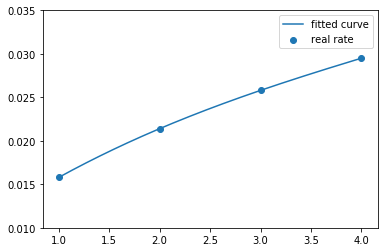

In [54]:
plt.scatter(data['term'],data['rate'])
plt.plot(test_term,fitted_rate)
plt.ylim([0.01,0.035])
plt.legend(['fitted curve','real rate'])

# Cubic Spline

In [ ]:
# 暂时没有手撕版...
from scipy.interpolate import CubicSpline

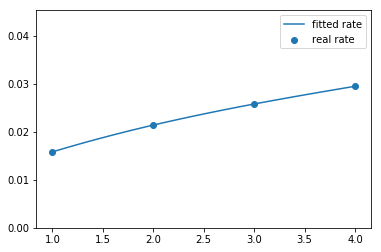

In [70]:
data = pd.DataFrame()
data['term'] = [i for i in range(1,5)]
data['rate'] = [0.0158,0.0214,0.0258,0.0295]
data.head()

cs = CubicSpline(data['term'],data['rate'])
x = np.linspace(1,4,20)
plt.scatter(data['term'],data['rate'])
plt.plot(x,cs(x))
plt.legend(['fitted rate','real rate'])

# Cubic Hermite Spline

## 手撕版

In [18]:
def hermite_fit(rate,term,ns):
    """
    ===== Function =====
    Fitting interest rate term structure using Hermite interpolate method.
    
    ===== Input =====
    rate : spot rate (%), harshable object.
    term : each term of spot rates (year), harshable object.
    ns : number of interpolated values in [s_i,s_i_1], int object.
    
    ===== Output =====
    interpolated spot rates in [s_0,s_n].
    """
    N = len(term)
    dR = []
    for i in range(N):
        
        if i == 0:       
            dr = (1/(term[2]-term[0])) * ( (term[2] + term[1] - 2 * term[0])*(rate[1] - rate[0])/(term[1] - term[0]) - \
                                           (term[1] - term[0])*(rate[2] - rate[1])/(term[2] - term[1]) ) 
            
        elif i>0 and i<len(term)-1:
            dr = (1/(term[i+1] - term[i-1])) * ( (term[i+1] - term[i])*(rate[i] - rate[i-1])/(term[i] - term[i-1]) + \
                                                 (term[i] - term[i-1])*(rate[i+1] - rate[i])/(term[i+1] - term[i]) )
            
        elif i == N-1:
            dr = (1/(term[i] - term[i-2])) * ( (term[i] - term[i-1])*(rate[i-1] - rate[i-2])/(term[i-1] - term[i-2]) - \
                                               (2*term[i] - term[i-1] - term[i-2])*(rate[i] - rate[i-1])/(term[i]-term[i-1]) )
        dR.append(dr)
    
    total = dict()
    for i in range(N-1):    
        fitted_rate = H(rate[i],rate[i+1],term[i],term[i+1],dR[i],dR[i+1],ns)
        total.update(fitted_rate) # update方法自动对字典元素去重
    
    return total

def H(R_i,R_i_1,s_i,s_i_1,dR_i,dR_i_1,ns=20):
    s = np.linspace(s_i,s_i_1,ns)
    fitted_rate = R_i * A((s-s_i)/(s_i_1-s_i) ,'i') + R_i_1 * A( (s-s_i)/(s_i_1-s_i) ,'i+1') + \
                  dR_i * B((s-s_i)/(s_i_1-s_i) ,'i') * (s_i_1 - s_i) + dR_i_1 * B((s-s_i)/(s_i_1-s_i) ,'i+1') * (s_i_1 - s_i)
    return dict(zip(s,fitted_rate))

def A(x,idx):
    if idx == 'i':
        return 2*(x**3) - 3*(x**2) + 1
    if idx == 'i+1':
        return -2*(x**3) + 3*(x**2)

def B(x,idx):
    if idx == 'i':
        return x**3 - 2*(x**2) + x
    if idx == 'i+1':
        return x**3 - x**2

In [3]:
data = pd.DataFrame()
# data['term'] = [i for i in range(0,30)]
# data['rate'] = np.random.random(30)/1000 + np.power([i for i in range(0,30)],1/8)/100
data['term'] = [i for i in range(1,5)]
data['rate'] = [0.0158,0.0214,0.0258,0.0295]
data.head()

,term,rate
0,1,0.0158
1,2,0.0214
2,3,0.0258
3,4,0.0295


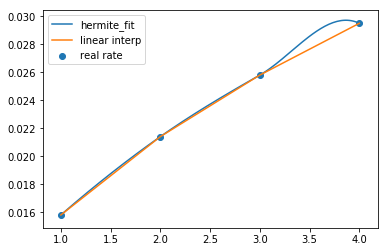

In [20]:
fitted_rate = hermite_fit(data['rate'],data['term'],50)
fig = plt.figure(figsize=(6,4))
plt.plot(fitted_rate.keys(),fitted_rate.values())
plt.plot(data['term'],data['rate'])
plt.scatter(data['term'],data['rate'])
plt.legend(['hermite_fit','linear interp','real rate'])

## 调包版（不太对）

In [2]:
from scipy.interpolate import CubicHermiteSpline

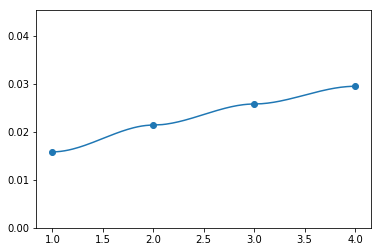

In [16]:
chs = CubicHermiteSpline(data['term'],data['rate'],[0,0,0,0])
x = np.linspace(1,4,150)
plt.scatter(data['term'],data['rate'])
plt.plot(x,chs(x))

# NS and NSS model

In [55]:
from functools import partial
from scipy.optimize import minimize

In [56]:
class static_model:
    def __init__(self,rate,term):
        self.rate = rate
        self.term = term
    
    def NS(self,params):
        beta_0 = params[0]
        beta_1 = params[1]
        beta_2 = params[2]
        m1 = params[3]
        fitted_rate = beta_0 + beta_1 * (1-np.exp(-self.term/m1))/(self.term/m1) + beta_2 * ((1-np.exp(-self.term/m1))/(self.term/m1) - np.exp(-self.term/m1))
        return fitted_rate
    
    def NSS(self,params):
        beta_0 = params[0]
        beta_1 = params[1]
        beta_2 = params[2]
        m1 = params[3]
        beta_3 = params[4]
        m2 = params[5]

        fitted_rate = beta_0 + beta_1 * (1-np.exp(-self.term/m1))/(self.term/m1) + beta_2 * ((1-np.exp(-self.term/m1))/(self.term/m1) - np.exp(-self.term/m1)) + \
               beta_3 * ((1-np.exp(-self.term/m2))/(self.term/m2) - np.exp(-self.term/m2))
        return fitted_rate
    
    def PricingError(self,model,params):
        if model == 'NS':
            fitted_rate = self.NS(params)
        if model == 'NSS':
            fitted_rate = self.NSS(params)
        err = np.power(fitted_rate - self.rate,2).sum()
        return err

    def calibration(self,model,init_params):
        obj = partial(self.PricingError,model)
        optim = minimize(obj,init_params,method = 'SLSQP')
        return optim['x']

In [57]:
# hypothetical spot rate data
data = pd.DataFrame()
data['term'] = [0.01*i for i in range(0,1500)]
data['rate'] = np.random.random(1500)/500 + np.power([i for i in range(0,1500)],1/8)/100
data.head()

,term,rate
0,0.00,0.000679
1,0.01,0.011967
2,0.02,0.012035
3,0.03,0.012561
4,0.04,0.013546


## Sensitivity Analysis

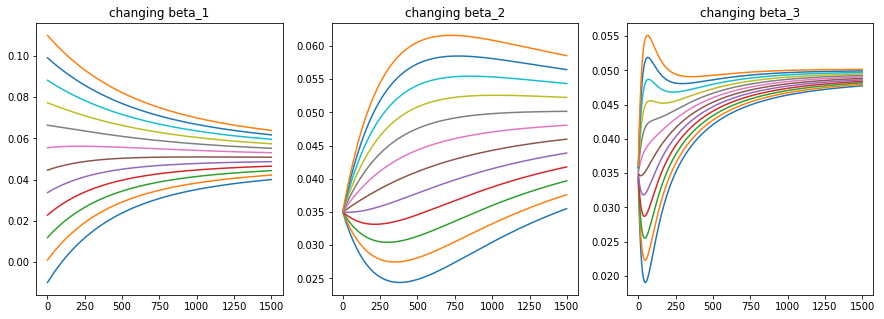

In [58]:
#sensitivity analysis
beta_0 = 0.05
beta_1 = -0.015
beta_2 = 0.01
m1 = 3
beta_3 = -0.01
m2 = 0.3

sm = static_model(data['rate'],data['term'])

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for beta_1 in np.linspace(-0.06,0.06,12):
    plt.plot(sm.NS([beta_0,beta_1,beta_2,m1]))
    plt.title('changing beta_1')

beta_1 = -0.015

plt.subplot(1,3,2)
for beta_2 in np.linspace(-0.06,0.06,12):
    plt.plot(sm.NS([beta_0,beta_1,beta_2,m1]))
    plt.title('changing beta_2')
    
beta_2 = 0.01

plt.subplot(1,3,3)
for beta_3 in np.linspace(-0.06,0.06,12):
    plt.plot(sm.NSS([beta_0,beta_1,beta_2,m1,beta_3,m2]))
    plt.title('changing beta_3')

## Calibration

In [61]:
sm = static_model(data['rate'],data['term'])
params_ns = sm.calibration(model='NS',init_params=[beta_0,beta_1,beta_2,m1])
params_nss = sm.calibration(model='NSS',init_params=[beta_0,beta_1,beta_2,m1,beta_3,m2])
print(params_ns)
print(params_nss)

[ 0.02691003 -0.01086255  0.00423493  3.00016382]
[ 0.02659988 -0.01355508  0.00738298  2.9997622   0.01043616  0.29896641]


(0.01, 0.03)

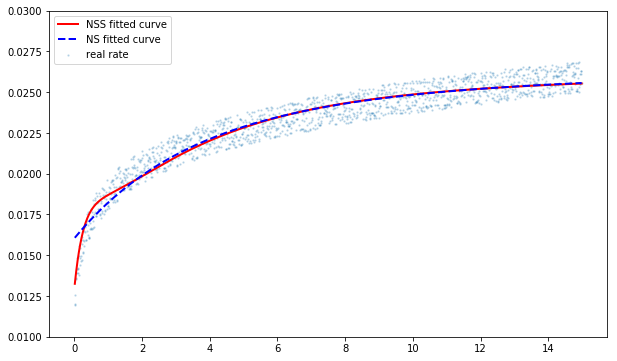

In [60]:
fig = plt.figure(figsize=(10,6))
plt.scatter(data['term'],data['rate'],alpha=0.2,s=2)
plt.plot(data['term'],sm.NSS(params_nss),'r-',linewidth=2)
plt.plot(data['term'],sm.NS(params_ns),'b--',linewidth=2)
plt.legend(['NSS fitted curve','NS fitted curve','real rate'])
plt.ylim([0.01,0.03])